# Dataset

In this homework, we will use the lead scoring dataset Bank Marketing dataset. [Download it from here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv).

In this dataset our desired target for classification task will be 'converted' variable - has the client signed up to the platform or not.


In [31]:
# Importing the libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Importing the dataset
!pip install wget
import wget
!wget wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

random_state=1
SEED = 1


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
--2025-10-20 18:08:22--  http://wget/
Resolving wget (wget)... failed: Name or service not known.
wget: unable to resolve host address ‘wget’
--2025-10-20 18:08:22--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv.2’

course_lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.004s  

2025-10-20 18:08:22 (18.8 MB/s) - ‘course_lead_scoring.csv.2’ saved [80876/80876]

FINISHED --2025-10-20 18:08:22--
Total wall clock time: 0.3s
Downloaded: 1 files, 79K in 0.004s (18.8 MB/s)


In [32]:
df = pd.read_csv('course_lead_scoring.csv')
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


# Data preparation

* Check if the missing values are presented in the features.
* If there are missing values:
  - For caterogiral features, replace them with 'NA'
  - For numerical features, replace with with 0.0
* Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1



In [33]:
# Check for missing values
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [34]:
def clean_transform(df):
    df = df.copy()

# If the column is categorical, replace the missing values with 'NA'
    categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
    
    for c in categorical_columns:
        df[c] = df[c].fillna('NA')
    
#For numerical features, replace with with 0.0
    num_columns = list(df.dtypes[(df.dtypes == 'int64') | (df.dtypes == 'float64')].index)
    
    for n in num_columns:
        df[n] = df[n].fillna(0.0)
    return df

In [35]:
def split_60_20_20(df, target):
    df = df.copy()
# Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. 
#Use train_test_split function for that with random_state=1
    
    from sklearn.model_selection import train_test_split
    df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
    df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
    print(len(df_train), len(df_val), len(df_test))

    df_full_train = df_full_train.reset_index(drop=True)
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    
# Target for classification task will be 'target' variable
    y_full_train = df_full_train[target].values
    y_train = df_train[target].values
    y_val = df_val[target].values
    y_test = df_test[target].values

    del df_train[target]
    del df_val[target]
    del df_test[target]
    return df_full_train, df_train, df_val, df_test, y_full_train, y_train, y_val, y_test

In [36]:
df = clean_transform(df)
df_full_train, df_train, df_val, df_test, y_full_train, y_train, y_val, y_test = split_60_20_20(df, target = 'converted')
df_train.head()

876 293 293


,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score
0,events,manufacturing,2,95543.0,unemployed,europe,3,0.78
1,referral,NA,1,54924.0,student,south_america,6,0.39
2,organic_search,healthcare,2,77352.0,unemployed,europe,2,0.22
3,paid_ads,other,2,34600.0,employed,south_america,2,0.31
4,paid_ads,education,0,43615.0,unemployed,south_america,2,0.01


Accuracy does not tell us how good a model is if there is a class imbalance. Only with balanced data (such as data that is 50/50, or a bit more varied than that) would accuracy be a good metric to use. We have to look at other evaluation metrics

# Question 1. ROC AUC feature importance
ROC AUC could also be used to evaluate feature importance of numerical variables.


* For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
* Use the training dataset for that
* If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['balance'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

### Which numerical variable (among the following 4) has the highest AUC?



In [37]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
scores = []
# Creating an array of evenly-spaced probabilities from 0 to 1 (aka 0, 0.1, 0.2, ..., 0.99, 1)
num_columns = [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col != "converted"]

# Printing true positives & negatives, false positives & negatives for each rate 
for n in num_columns:
    auc = roc_auc_score(y_train, df_train[n])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[n])
    
    # List of tuples is created per threshold
    scores.append((n, auc))
scores

[('number_of_courses_viewed', 0.7635680590007088),
 ('annual_income', 0.5519578313253012),
 ('interaction_count', 0.738270176293409),
 ('lead_score', 0.6144993577250176)]

### Answer: 'number_of_courses_viewed' has the highest AUC

# Question 2: Training the model

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
### What's the AUC of this model on the validation dataset? (round to 3 digits)



In [38]:
# let's apply one-hot encoding

from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)


X_train.shape, X_val.shape

((876, 31), (293, 31))

In [39]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=1)
model.fit(X_train, y_train)

# Let's get the accuracy on a validation dataset
y_pred = model.predict_proba(X_val)[:, 1]

from sklearn.metrics import roc_curve
roc_auc_score(y_test, y_pred)

0.5212059274399591

### Answer: the AUC of this model on the validation dataset is 0.52

# Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them
### At which threshold precision and recall curves intersect?


In [40]:
# Recall linspace produces an nparray with equal 'spacings'
thresholds = np.linspace(0.0, 1.0, 101)

scores = []

# Printing threshold, printing accuracy score with the threshold 
for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    scores.append((t, precision.round(2), recall.round(2)))

/tmp/ipykernel_11654/4077058190.py:20: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


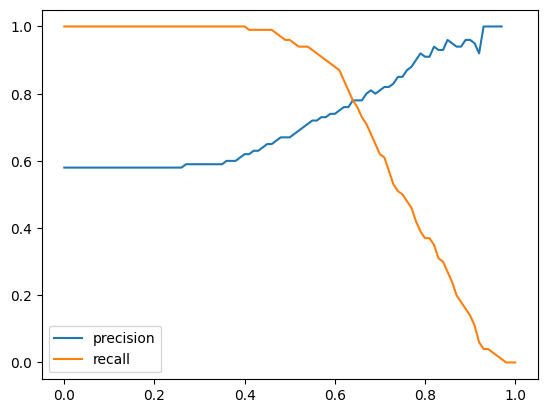

In [41]:
# Creating a dataframe for these scores so that we are able model the TPRs and FPRs for each threshold
columns = ['threshold', 'precision', 'recall']
df_scores = pd.DataFrame(scores, columns=columns)

plt.plot(df_scores["threshold"], df_scores["precision"], label="precision")
plt.plot(df_scores["threshold"], df_scores["recall"], label="recall")
plt.legend();

In [42]:
df_scores = df_scores.reset_index()  # make sure indexes pair with number of rows
a = []
for index, row in df_scores.iterrows():
    if row['precision'] == row['recall']:
        a = row['threshold']
a

np.float64(0.64)

In [43]:
df_scores['diff'] = df_scores['precision'] - df_scores['recall']
df_scores[df_scores['diff'] == 0]

,index,threshold,precision,recall,diff
64,64,0.64,0.78,0.78,0.0


### Answer: At threshold 0.64 precision and recall curves intersect

# Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. 

That's why they are often combined into the F1 score - a metrics that takes into account both.
### At which threshold F1 is maximal?

In [44]:
# Recall linspace produces an nparray with equal 'spacings'
thresholds = np.linspace(0.0, 1.0, 101)

f1_scores = []

# Printing threshold, printing accuracy score with the threshold 
for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2* (precision * recall)/(precision + recall)
    f1_scores.append((t, f1))

# Creating a dataframe for these scores so that we are able model the TPRs and FPRs for each threshold
columns = ['threshold', 'f1']
df_f1_scores = pd.DataFrame(f1_scores, columns=columns)

/tmp/ipykernel_11654/4250143229.py:20: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


In [45]:
df_f1_scores.f1.sort_values(ascending=False)

57     0.812500
55     0.811224
56     0.809278
59     0.808511
58     0.808399
         ...   
96     0.034483
97     0.011628
98          NaN
99          NaN
100         NaN
Name: f1, Length: 101, dtype: float64

In [46]:
df_f1_scores.iloc[57]

threshold    0.5700
f1           0.8125
Name: 57, dtype: float64

###Answer: 57

### Answer: 57

# Question 5: 5-Fold CV

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

* KFold(n_splits=5, shuffle=True, random_state=1)
* Iterate over different folds of df_full_train
* Split the data into train and validation
* Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
* Use AUC to evaluate the model on validation
### How large is standard deviation of the scores across different folds?



In [47]:
from sklearn.model_selection import KFold
!pip install tqdm
# tqdm allows you to see the process for each iteration 
from tqdm.auto import tqdm


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [48]:
df_full_train.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,referral,NA,1,56659.0,employed,asia,4,0.75,1
1,social_media,education,2,66171.0,unemployed,north_america,2,0.66,0
2,events,finance,1,66523.0,self_employed,europe,3,0.64,1
3,social_media,finance,1,56746.0,student,north_america,3,0.98,0
4,referral,NA,0,55449.0,student,australia,4,0.47,0


In [49]:
y_full_train

array([1, 0, 1, ..., 0, 1, 1], shape=(1169,))

In [58]:
def train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')
 
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
 
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
 
    return dv, model

In [55]:
def predict(df, dv, model):
     dicts = df.to_dict(orient='records')
 
     X = dv.fit_transform(dicts)
     y_pred = model.predict_proba(X)[:,1]
 
     return y_pred


In [56]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)  
scores = []
 
for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
 
    y_train = df_train.converted.values
    y_val = df_val.converted.values
 
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
 
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

0it [00:00, ?it/s]

In [59]:
print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.876 +- 0.032


### Answer: standard deviation of the scores across different folds = 0.032

The standard deviation reflects the model’s stability and how scores vary across different folds.

# Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: [0.000001, 0.001, 1]
* Initialize KFold with the same parameters as previously
* Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)
### Which C leads to the best mean score?

In [60]:
from sklearn.model_selection import KFold
 
n_splits = 5
 
for C in tqdm([0.000001, 0.001, 1]):   
    scores = []
 
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)  
 
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
 
        y_train = df_train.converted.values
        y_val = df_val.converted.values
 
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
 
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
 
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/3 [00:00<?, ?it/s]

C=1e-06 0.561 +- 0.024
C=0.001 0.926 +- 0.018
C=1 0.876 +- 0.032


### Answer: C=0.001 leads ro the biggest 